In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 75.2 MB/s eta 0:00:00


In [3]:
import os

# Path where training data is stored
train_data_path = "/content/drive/MyDrive/Dataset/splitset/"

# Get participant IDs from existing training files
train_participants = [
    file.split("_")[0] for file in os.listdir(train_data_path) if file.endswith("_train.mat")
]
train_participants = sorted(set(map(int, train_participants)))  # Ensure unique and sorted IDs

print("Loaded train participants:", train_participants)

Loaded train participants: [1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 29, 30, 31, 32, 33, 35, 36, 37, 39, 42, 43, 45, 46, 47, 48]


In [4]:
import numpy as np
import scipy.io
import pywt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import joblib

sampling_rate = 256

# Define frequency bands
theta_band = (4, 8)
low_beta_band = (13, 20)

# Specify the channels to use
selected_channels = [3, 5, 8, 14, 17, 19, 24, 25, 36, 39, 40, 45, 47, 52, 53]
selected_channels = [ch - 1 for ch in selected_channels]  # Convert to 0-based indexing

# Function to compute power using CWT
def compute_power_cwt(signal, scales, wavelet):
    coefficients, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1.0/sampling_rate)
    return np.abs(coefficients) ** 2  # Power

# Initialize list to store features for the entire training set
all_theta_low_beta_features = []

# Loop through each participant
for participant in train_participants:
    # Load the .mat file for the participant
    train_file_path = f'/content/drive/MyDrive/Dataset/splitset/{int(participant)}_train.mat'
    data = scipy.io.loadmat(train_file_path)

    # Extract the EEG data (key is 'train_data' in the .mat file)
    participant_data = data['train_data']  # Shape: (timepoints, channels, trials)
    num_timepoints, num_channels, num_trials = participant_data.shape

    # Group trials into 20-second segments
    trial_duration = 1.5  # Duration of each trial in seconds
    segment_duration = 20  # Desired segment duration in seconds
    trials_per_segment = int(segment_duration / trial_duration)  # Number of trials per 20-second segment=13 trials

    # Extract 5-second windows from each 20-second segment
    window_duration = 5  # Duration of each window in seconds
    window_length = window_duration * sampling_rate  # Length of each window in samples
    overlap = 0.5  # 50% overlap between windows
    step_size = int(window_length * (1 - overlap))  # Step size for overlapping windows

    for start in range(0, num_trials - trials_per_segment + 1, trials_per_segment):
        # Extract 20-second segment for selected channels
        segment_data = participant_data[:, selected_channels, start:start + trials_per_segment]  # Shape: (timepoints, selected_channels, trials_per_segment)
        segment_signal = segment_data.reshape(-1, segment_data.shape[1])  # Flatten trials into a single time series

        # Ensure the segment is exactly 20 seconds
        segment_signal = segment_signal[:20 * sampling_rate, :]

        # Extract 5-second windows with overlap
        for i in range(0, len(segment_signal) - window_length + 1, step_size):
            window_signal = segment_signal[i:i + window_length, :]  # Shape: (window_length, selected_channels)

            # Compute theta/low-beta ratios for the window
            wavelet = 'cmor1.0-0.5'  # Complex Morlet wavelet

            # Compute scales using pywt.frequency2scale
            scales_theta = pywt.frequency2scale(wavelet, np.array(theta_band) / sampling_rate)
            scales_low_beta = pywt.frequency2scale(wavelet, np.array(low_beta_band) / sampling_rate)

            window_theta_low_beta = []

            for channel in range(len(selected_channels)):
                # Compute CWT for the channel
                theta_power = compute_power_cwt(window_signal[:, channel], scales_theta, wavelet).mean(axis=0)
                low_beta_power = compute_power_cwt(window_signal[:, channel], scales_low_beta, wavelet).mean(axis=0)

                # Compute ratio
                theta_low_beta_ratio = theta_power / low_beta_power

                window_theta_low_beta.append(theta_low_beta_ratio.mean())  # Average ratio over time

            # Aggregate features over channels
            all_theta_low_beta_features.append(np.mean(window_theta_low_beta))

# Convert features to numpy array and reshape for clustering
all_theta_low_beta_features = np.array(all_theta_low_beta_features).reshape(-1, 1)

# Save the features to a .npy file
save_path = "/content/drive/MyDrive/Dataset/features/adhd_tlbr_values.npy"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
np.save(save_path, all_theta_low_beta_features)

print(f"Saved {all_theta_low_beta_features.shape[0]} TLBR values to: {save_path}")

Saved 3372 TLBR values to: /content/drive/MyDrive/Dataset/features/adhd_tlbr_values.npy


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib

# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_theta_low_beta_features)

# Save the scaler for later use
scaler_path = "/content/drive/MyDrive/Dataset/clustering_models/Kmeans_TLBR_Scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Save normalized ADHD features
adhd_features_path = "/content/drive/MyDrive/Dataset/features/normalized_adhd_features.npy"
np.save(adhd_features_path, normalized_features)  # normalized_features is what you clustered with
print(f"Normalized ADHD features saved to {adhd_features_path}")

# Save raw ADHD features
raw_feature_path = "/content/drive/MyDrive/Dataset/features/raw_theta_low_beta_adhd.npy"
np.save(raw_feature_path, all_theta_low_beta_features)


Scaler saved to /content/drive/MyDrive/Dataset/clustering_models/Kmeans_TLBR_Scaler.pkl
Normalized ADHD features saved to /content/drive/MyDrive/Dataset/features/normalized_adhd_features.npy


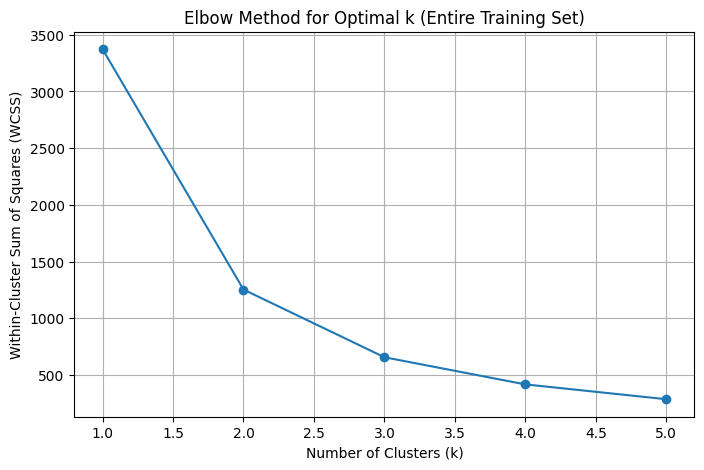

In [6]:
#Determine the optimal number of clusters using the elbow method
wcss = []
K_range = range(1, 6)  # Test 1 to 5 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_features)
    wcss.append(kmeans.inertia_)  # Inertia (within-cluster sum of squares)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k (Entire Training Set)')
plt.grid()
plt.show()

For n_clusters = 2, the average silhouette score is 0.553
For n_clusters = 3, the average silhouette score is 0.533
For n_clusters = 4, the average silhouette score is 0.518
For n_clusters = 5, the average silhouette score is 0.525
For n_clusters = 6, the average silhouette score is 0.521


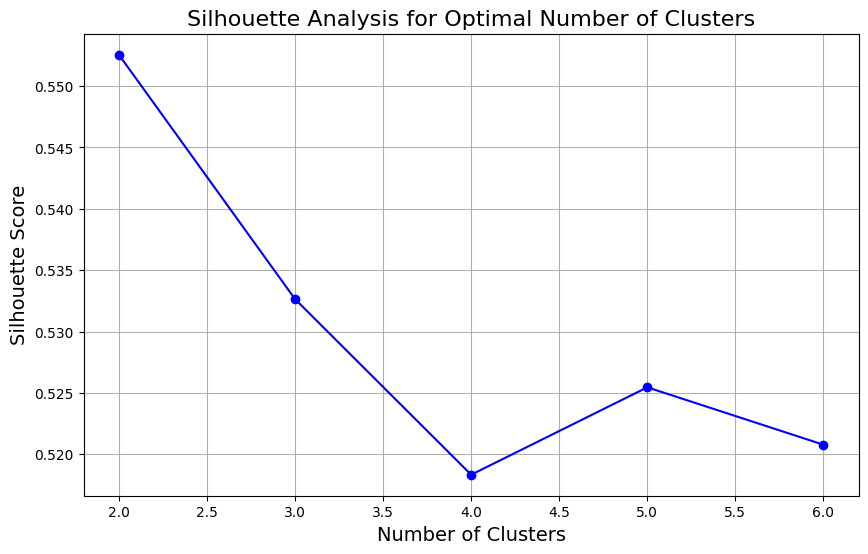

In [7]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Apply the silhouette method
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_scores = []

# Loop through different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(normalized_features)
    silhouette_avg = silhouette_score(normalized_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.title("Silhouette Analysis for Optimal Number of Clusters", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.grid()
plt.show()

For n_clusters = 2, the Davies-Bouldin Index is 0.606
For n_clusters = 3, the Davies-Bouldin Index is 0.563
For n_clusters = 4, the Davies-Bouldin Index is 0.557
For n_clusters = 5, the Davies-Bouldin Index is 0.542
For n_clusters = 6, the Davies-Bouldin Index is 0.555


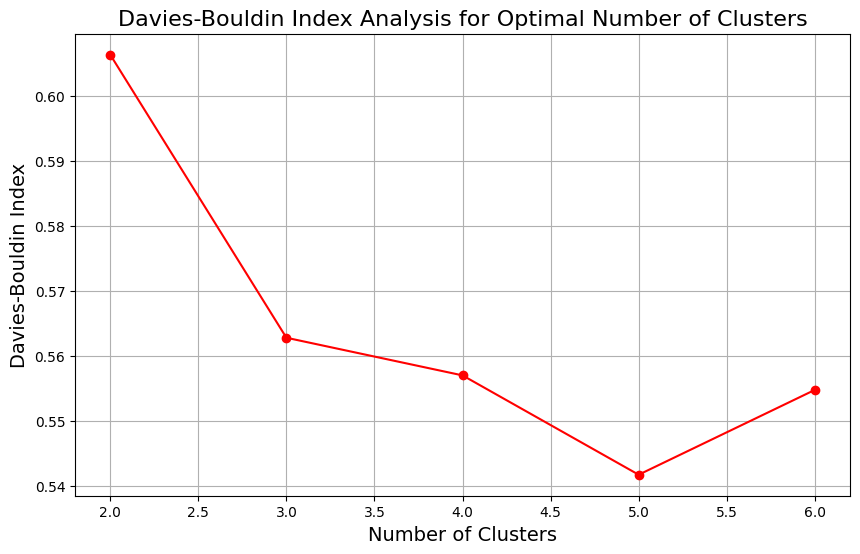

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

range_n_clusters = [2, 3, 4, 5, 6]
dbi_scores = []

# Loop through different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(normalized_features)
    dbi_score = davies_bouldin_score(normalized_features, cluster_labels)
    dbi_scores.append(dbi_score)
    print(f"For n_clusters = {n_clusters}, the Davies-Bouldin Index is {dbi_score:.3f}")

# Plot DBI scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, dbi_scores, marker='o', linestyle='-', color='red')
plt.title("Davies-Bouldin Index Analysis for Optimal Number of Clusters", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Davies-Bouldin Index", fontsize=14)
plt.grid()
plt.show()



Model saved to /content/drive/MyDrive/Dataset/clustering_models/Kmeans_TLBR_Model.pkl
Centroids: [[ 0.04018557]
 [-1.1122932 ]
 [ 1.3392987 ]]


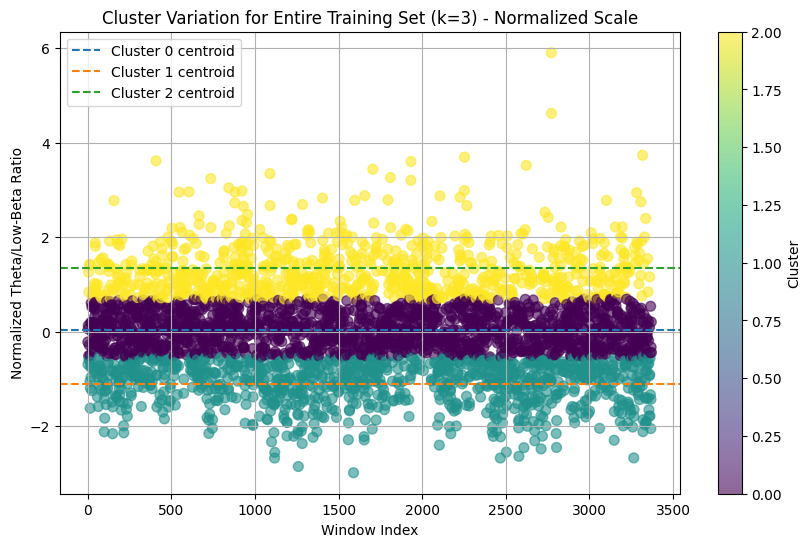

In [9]:
# Perform K-Means clustering on normalized features
optimal_k = 3  # Set based on the elbow method

kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(normalized_features)

# Save the model for later use
model_path = "/content/drive/MyDrive/Dataset/clustering_models/Kmeans_TLBR_Model.pkl"
joblib.dump(kmeans, model_path)
print(f"Model saved to {model_path}")

centroids = kmeans.cluster_centers_
print(f"Centroids: {centroids}")

# Plotting with Normalized Features
plt.figure(figsize=(10, 6))

# Since we only have one feature dimension, we'll plot against index with cluster colors
plt.scatter(range(len(normalized_features)), normalized_features, c=clusters, cmap='viridis', s=50, alpha=0.6)

# Plot centroids
for i, centroid in enumerate(centroids):
    plt.axhline(y=centroid, color=f'C{i}', linestyle='--', label=f'Cluster {i} centroid')

plt.xlabel('Window Index')
plt.ylabel('Normalized Theta/Low-Beta Ratio')
plt.title(f'Cluster Variation for Entire Training Set (k={optimal_k}) - Normalized Scale')
plt.colorbar(label='Cluster')
plt.legend()
plt.grid()
plt.show()

Cluster 0 -> Mid attention                 
Cluster 1 -> High Attention        
Cluster 2 -> Low Attention